In [1]:
import os
from bs4 import BeautifulSoup
import string
from nltk.tokenize import RegexpTokenizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.models import load_model
from keras.layers.core import Dense, Activation
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from keras.utils import to_categorical
import pickle
from keras.optimizers import RMSprop
import numpy as np
from numpy import array
import heapq

2023-02-25 08:51:35.545732: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-25 08:51:39.687079: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-25 08:51:39.687108: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-02-25 08:51:47.592203: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [2]:
documents = []
for file in os.listdir("reuters_sample/"): # original: "reuters_data/"
    if file.endswith('.sgm'): # it is important for GoogleColab
        filename = os.path.join("reuters_sample", file) # original: "reuters_data"
        f = open(filename, 'r', encoding='utf-8', errors='ignore')
        dataFile = f.read().lower()
        
        soup = BeautifulSoup(dataFile, 'html.parser')

        ## get all 'topic'
        # topics = {topic.name for topic in soup.find_all()}
  
        ## iterate all 'topic'
        # for topic in topics:
          
        ## find all element of 'topic'
          # for i in soup.find_all('topic'):
  
        ## if tag has attribute of class
            # if i.has_attr('trade'):
  
# We have selected the following 20 'TOPICS' out of 135:
# that we want to use for our prediction exercise: 1.) "trade" 2.) "earn" 3.) "grain" 4.) "money-fx" 5.) 
# "coffee" 6.) "gold" 7.) "acq" 8.) "wheat" 9.) "veg-oil" 10.) "nat-gas" 11.) "cooper" 12.) "ship" 13.) 
# "dlr" 14.) "crude" 15.) "interest" 16.) "meal-feed" 17.) "alum" 18.) "money-supply" 19.) "cocoa" 20.) "livestock"
        contents = soup.findAll('title')
        
        for content in contents:
            documents.append(content.text)

In [3]:
documents = [i for n, i in enumerate(documents) if i not in documents[:n]]

print('Number of documents: {}'.format(len(documents)))

Number of documents: 6731


In [4]:
data = ""
for d in documents:
    data += d

In [5]:
# improve punctuation
data = data.replace('\n', '').replace('\r', '').replace('\ufeff', '')
print('Number of data: {}'.format(len(data)))
print(data[:100])

Number of data: 302335
bahia cocoa reviewstandard oil <srd> to form financial unittexas commerce bancshares <tcb> files pla


In [6]:
translator = str.maketrans(string.punctuation, ' '*len(string.punctuation)) #map punctuation to space
data = data.translate(translator)
print(data[:100])

bahia cocoa reviewstandard oil  srd  to form financial unittexas commerce bancshares  tcb  files pla


In [7]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts([data])
# saving the tokenizer for predict function.
pickle.dump(tokenizer, open('tokenizer.pkl', 'wb'))

encoded_data = tokenizer.texts_to_sequences([data])[0]
print(len(encoded_data))
encoded_data[:5]

44856


[3302, 513, 3303, 29, 1457]

In [8]:
unique_words = np.unique(encoded_data)
vocab_size = len(unique_words) + 1  # 0 is reserved for padding so that's why we added 1
unique_word_index = dict((c, i) for i, c in enumerate(unique_words))
print('Vocabulary Size: %d' % vocab_size)

Vocabulary Size: 13007


In [9]:
WORD_LENGTH = 5
prev_words = []
next_words = []
for i in range(1, len(encoded_data) - WORD_LENGTH):
    prev_words.append(encoded_data[i:i + WORD_LENGTH])
    next_words.append(encoded_data[i + WORD_LENGTH])
print(prev_words[0])
print(next_words[0])

[513, 3303, 29, 1457, 1]
558


In [10]:
X = prev_words
X = np.array(X)
Y = next_words
Y = np.array(Y)


In [11]:
# one hot encode outputs
Y = to_categorical(Y, num_classes=vocab_size)
# define model
Y[:5]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [12]:
model = Sequential()
model.add(Embedding(vocab_size, 10, input_length=1)) # original: 5
model.add(LSTM(32, return_sequences=True, input_shape=(WORD_LENGTH, len(unique_words))))
model.add(LSTM(32, return_sequences=True))
model.add(LSTM(32))
model.add(Dense(vocab_size, activation='softmax'))
print(model.summary())

2023-02-25 08:52:04.843146: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1, 10)             130070    
                                                                 
 lstm (LSTM)                 (None, 1, 32)             5504      
                                                                 
 lstm_1 (LSTM)               (None, 1, 32)             8320      
                                                                 
 lstm_2 (LSTM)               (None, 32)                8320      
                                                                 
 dense (Dense)               (None, 13007)             429231    
                                                                 
Total params: 581,445
Trainable params: 581,445
Non-trainable params: 0
_________________________________________________________________
None


2023-02-25 08:52:04.852106: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-02-25 08:52:04.852161: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (bishal-pc): /proc/driver/nvidia/version does not exist
2023-02-25 08:52:04.874691: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [13]:
optimizer = RMSprop(lr= 0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

history = model.fit(X, Y, validation_split=0.05, batch_size=128, epochs=20, shuffle=True).history

/home/dell/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/rmsprop.py:143: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
2023-02-25 08:52:07.126903: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 2216756996 exceeds 10% of free system memory.


Epoch 1/20
333/333 [==============================] - 22s 42ms/step - loss: 8.0643 - accuracy: 0.0394 - val_loss: 8.0302 - val_accuracy: 0.0584
Epoch 2/20
333/333 [==============================] - 12s 37ms/step - loss: 7.6323 - accuracy: 0.0610 - val_loss: 8.0246 - val_accuracy: 0.0593
Epoch 3/20
333/333 [==============================] - 12s 37ms/step - loss: 7.5475 - accuracy: 0.0686 - val_loss: 8.3554 - val_accuracy: 0.0758
Epoch 4/20
333/333 [==============================] - 12s 37ms/step - loss: 7.6671 - accuracy: 0.0770 - val_loss: 8.7344 - val_accuracy: 0.0762
Epoch 5/20
333/333 [==============================] - 12s 37ms/step - loss: 7.8780 - accuracy: 0.0877 - val_loss: 9.0334 - val_accuracy: 0.0802
Epoch 6/20
333/333 [==============================] - 12s 37ms/step - loss: 7.8459 - accuracy: 0.0985 - val_loss: 9.1006 - val_accuracy: 0.0794
Epoch 7/20
333/333 [==============================] - 11s 33ms/step - loss: 7.7362 - accuracy: 0.1078 - val_loss: 9.2164 - val_accuracy:

In [14]:
SEQUENCE_LENGTH = 39

In [15]:
#Saving
model.save('keras_model'+str(SEQUENCE_LENGTH)+'.h5')
pickle.dump(history, open('history'+str(SEQUENCE_LENGTH)+'.p', 'wb'))



#Loading back the saved weights and history

model = load_model('keras_model'+str(SEQUENCE_LENGTH)+'.h5')
history = pickle.load(open('history'+str(SEQUENCE_LENGTH)+'.p', 'rb'))

In [19]:
import matplotlib.pyplot as plt
import matplotlib


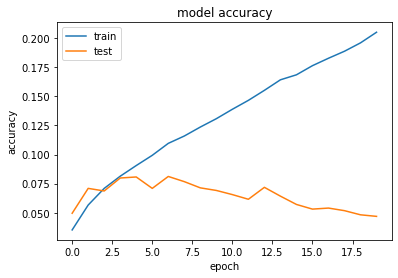

In [21]:
#Evaluation
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc= 'upper left')

plt.savefig("01.Accuracy.png")



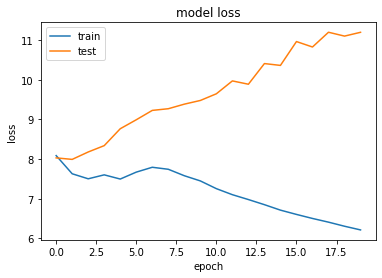

In [22]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc= 'upper left')

plt.savefig("02.Loss.png")

In [18]:
#Prediction Script
# Importing the Libraries

from tensorflow.keras.models import load_model
import numpy as np
import pickle

# Load the model and tokenizer
model = load_model('keras_model'+str(SEQUENCE_LENGTH)+'.h5')
tokenizer = pickle.load(open('tokenizer.pkl', 'rb'))



In [33]:
def Predict_Next_Words(model, tokenizer, text):
    for i in range(5):
        sequence = tokenizer.texts_to_sequences([text])[0]
        sequence = np.array(sequence)
        
        preds = model.predict_classes(sequence)
        predicted_word = ""
        print(preds)
        for key, value in tokenizer.word_index.items():
            if value == preds:
                predicted_word = key
                break
        return predicted_word

Enter your line: abc
Enter your line: bgft
Enter your line: i love her 
Enter your line: with my heart


KeyboardInterrupt: Interrupted by user

In [20]:
tokenizer

In [23]:
encoded_data = tokenizer.texts_to_sequences([data])[0]
print((encoded_data))

[3302, 513, 3303, 29, 1457, 1, 558, 98, 1458, 559, 822, 3304, 66, 3305, 230, 965, 560, 390, 3306, 450, 121, 8, 3307, 3308, 3309, 59, 616, 231, 3310, 3311, 1986, 3312, 66, 77, 3313, 725, 32, 3314, 35, 300, 3315, 301, 3316, 203, 37, 3317, 1163, 88, 3318, 90, 3319, 5, 3320, 18, 3321, 1987, 1988, 60, 272, 133, 36, 4, 3322, 67, 5, 726, 58, 4, 17, 3323, 1164, 5, 1989, 7, 4, 1459, 3324, 3325, 1, 72, 3326, 3327, 273, 965, 560, 204, 419, 3328, 3329, 21, 3330, 561, 3331, 19, 475, 7, 4, 3332, 85, 1990, 8, 420, 3333, 3334, 1460, 1165, 514, 3335, 164, 16, 165, 110, 43, 1461, 3336, 562, 421, 64, 318, 1991, 1, 1992, 3337, 1164, 1993, 12, 37, 285, 210, 3338, 1462, 22, 391, 5, 3339, 7, 3340, 1994, 136, 21, 1463, 3341, 286, 3342, 11, 1995, 3343, 1996, 6, 3344, 7, 4, 3345, 286, 3346, 247, 2, 727, 10, 3347, 515, 34, 516, 341, 41, 3348, 10, 56, 52, 1166, 617, 148, 3349, 62, 9, 25, 3, 476, 1997, 2, 69, 1464, 219, 563, 69, 1465, 966, 74, 71, 27, 25, 3350, 3351, 1998, 134, 1167, 728, 3352, 5, 12, 122, 37, 335